| | |
| --- | --- |
| **Author** | Pierre Alexander Burger |
| **email** | pburger@uwatelroo.ca |

---
---
# **INTRODUCTION**
---
---

In this notebook, we will train a neural network emulator based on JAX on the summary statistics (galaxy clustering, galaxy-galaxy lensing, and cosmic shear) of the 3x2pt of DES Y3 when varying $\omega_\mathrm{m}$, $\omega_\mathrm{b}$, $A_s$, and $w$. We use the ``cosmoemu_jax``. The structure of this notebook is identical to https://github.com/alessiospuriomancini/cosmopower/blob/main/notebooks/training_notebooks/cosmopower_NN_3times2pt.ipynb to allow a direct comparison with CosmoPower

---
---
# **PRELIMINARY OPERATIONS** 
---
---

We will start with a few imports, as well as with checking that the notebook is running on a GPU - this is strongly recommended to speed up training.

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os

import jax
# from jax.config import config
# config.update("jax_platform_name", "METAL") # Comment this in if you wanto to use the GPU
print(jax.devices())

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M3 Max

systemMemory: 48.00 GB
maxCacheSize: 18.00 GB

[METAL(id=0)]


2025-05-28 12:10:34.279974: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


We will also set the random seed, for reproducibility of results. 

In [2]:
# setting the seed for reproducibility
np.random.seed(1)

---
---
# **TRAINING/TESTING DATA DOWNLOAD**
---
---

Here, we will load the datasets for training and testing our emulator.

For the illustrative purposes of this notebook, we will use datasets of modest size. These files can be downloaded with the provided gdrive id files.

In [3]:
# import gdown
# gdown.download(id='10r39tzOxNRYOIU1adO6qmqBrPdgkEb_1',output='outputs/models.npy')
# gdown.download(id='1GI-y3-e_US6RIimrR9uHuUX4jeKrdQ-M',output='outputs/parameters.npz')



In [4]:
models = np.load('outputs/models.npy')
parameters = np.load('outputs/parameters.npz')
parameters.keys(),models.shape

train_sample = np.arange(0,2000)
test_sample = np.arange(2000,10000)

train_params = {}
for name in parameters.keys():
    train_params[name]=jnp.array(parameters[name])[train_sample]
    
test_params = {}
for name in parameters.keys():
    test_params[name]= jnp.array(parameters[name])[test_sample]

train_features = jnp.array(models[train_sample])
test_features = jnp.array(models[test_sample])

para_names = list(train_params.keys())

Let’s first inspect our input features. As we can see, they vary over a large range of values and have negative values. Therefore, using the log10 of these features is not possible.

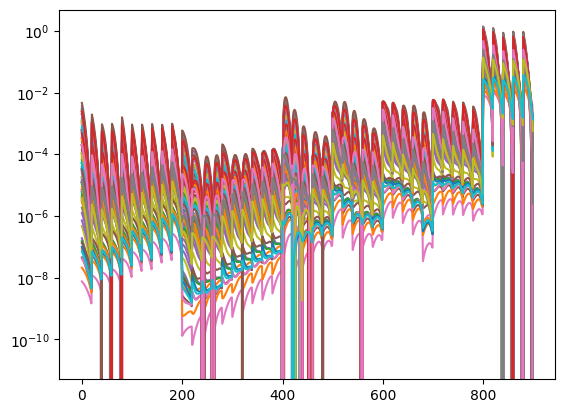

In [5]:
for i in range(100):
    plt.plot(train_features[i])
plt.yscale('log')

Next, we load in the ``cosmopower_NN`` module and train an emulator using 2k features.

In [6]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,
    
    normalise_mode='mean_sigma',

    learning_rate=1e-3,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=False,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 0.927692, Val Loss: 0.784931
Epoch   50, Train Loss: 0.069268, Val Loss: 0.059815
Epoch  100, Train Loss: 0.031367, Val Loss: 0.026403
Epoch  150, Train Loss: 0.038883, Val Loss: 0.036227
Epoch  200, Train Loss: 0.036699, Val Loss: 0.032413
Epoch  250, Train Loss: 0.023336, Val Loss: 0.021075
Epoch  300, Train Loss: 0.036855, Val Loss: 0.028039
Epoch  350, Train Loss: 0.033284, Val Loss: 0.024932
Epoch  400, Train Loss: 0.017124, Val Loss: 0.014364
Epoch  450, Train Loss: 0.027989, Val Loss: 0.022377
Epoch  500, Train Loss: 0.016303, Val Loss: 0.014803
Epoch  550, Train Loss: 0.031395, Val Loss: 0.026323
Epoch  600, Train Loss: 0.014372, Val Loss: 0.013734
Epoch  650, Train Loss: 0.017957, Val Loss: 0.013189
Training complete. Best val loss: 0.010294. Model saved to outputs/jax_env


In [6]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,
    
    normalise_mode='mean_sigma',

    learning_rate=1e-3,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=False,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 0.921407, Val Loss: 0.781489
Epoch   50, Train Loss: 0.065144, Val Loss: 0.061199
Epoch  100, Train Loss: 0.038868, Val Loss: 0.036000
Epoch  150, Train Loss: 0.043442, Val Loss: 0.038089
Epoch  200, Train Loss: 0.023306, Val Loss: 0.022444
Epoch  250, Train Loss: 0.042232, Val Loss: 0.031715
Epoch  300, Train Loss: 0.018193, Val Loss: 0.016659
Epoch  350, Train Loss: 0.020093, Val Loss: 0.015658
Epoch  400, Train Loss: 0.026326, Val Loss: 0.021345
Epoch  450, Train Loss: 0.026689, Val Loss: 0.024374
Epoch  500, Train Loss: 0.027427, Val Loss: 0.022148
Epoch  550, Train Loss: 0.021007, Val Loss: 0.020314
Epoch  600, Train Loss: 0.033040, Val Loss: 0.025394
Epoch  650, Train Loss: 0.044002, Val Loss: 0.033558
Epoch  700, Train Loss: 0.031705, Val Loss: 0.022783
Epoch  750, Train Loss: 0.018650, Val Loss: 0.016431
Epoch  800, Train Loss: 0.021357, Val Loss: 0.020710
Epoch  850, Train Loss: 0.020529, Val Loss: 

Loading model from outputs/jax_env.npz
Loaded keys: KeysView(NpzFile 'outputs/jax_env.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


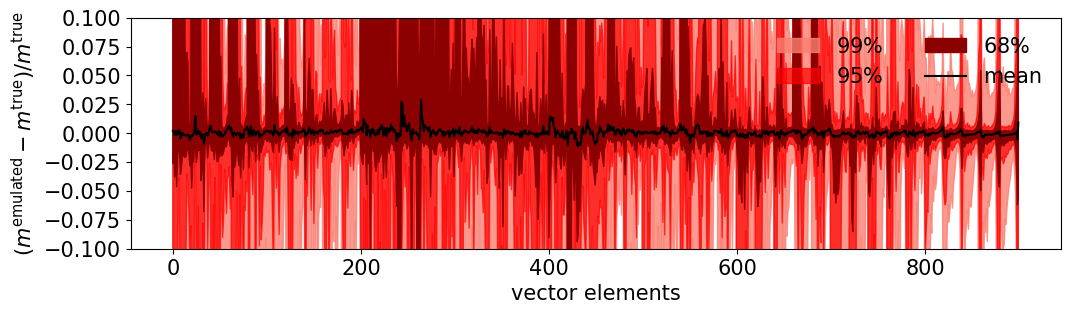

In [7]:
jax_nn = EmulatorJAX(filepath=f'outputs/jax_env.npz')
emulated_features = jax_nn.rescaled_predict(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emulated models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = r'$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = r'$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = r'$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

In [8]:
# === Train Emulator ===
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,
    
    normalise_mode='min_max',

    learning_rate=1e-3,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=False,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env_minmax',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 0.259401, Val Loss: 0.240414
Epoch   50, Train Loss: 0.030132, Val Loss: 0.024431
Epoch  100, Train Loss: 0.016495, Val Loss: 0.014682
Epoch  150, Train Loss: 0.012833, Val Loss: 0.011330
Epoch  200, Train Loss: 0.011730, Val Loss: 0.009892
Epoch  250, Train Loss: 0.016111, Val Loss: 0.015300
Epoch  300, Train Loss: 0.009574, Val Loss: 0.008158
Epoch  350, Train Loss: 0.011190, Val Loss: 0.009292
Epoch  400, Train Loss: 0.009567, Val Loss: 0.007986
Epoch  450, Train Loss: 0.004798, Val Loss: 0.004178
Epoch  500, Train Loss: 0.005759, Val Loss: 0.005068
Epoch  550, Train Loss: 0.005545, Val Loss: 0.005050
Epoch  600, Train Loss: 0.007852, Val Loss: 0.006546
Epoch  650, Train Loss: 0.003355, Val Loss: 0.003281
Epoch  700, Train Loss: 0.007231, Val Loss: 0.006034
Epoch  750, Train Loss: 0.003584, Val Loss: 0.003266
Epoch  800, Train Loss: 0.005180, Val Loss: 0.004804
Epoch  850, Train Loss: 0.006006, Val Loss: 

Loading model from outputs/jax_env_minmax.npz
Loaded keys: KeysView(NpzFile 'outputs/jax_env_minmax.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


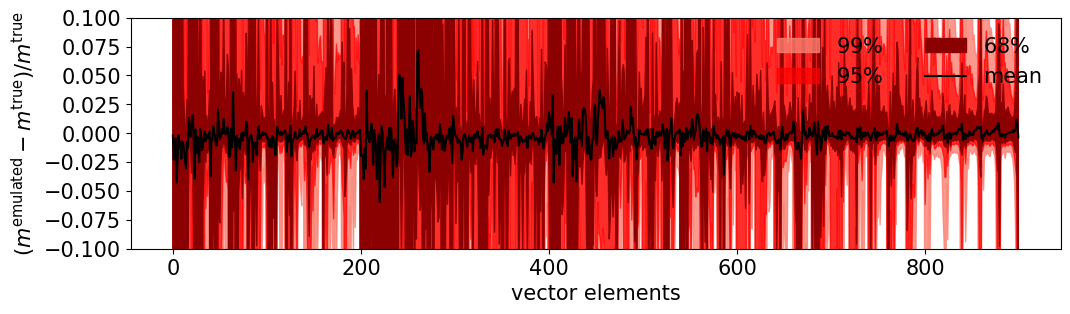

In [9]:
jax_nn = EmulatorJAX(filepath=f'outputs/jax_env_minmax.npz')
emulated_features = jax_nn.rescaled_predict(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = r'$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = r'$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = r'$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

In [10]:
# === Train Emulator ===
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=train_features,

    normalise_mode='mean_sigma', # determines thw way the input and out features are normalised

    learning_rate=1e-1,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[512] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=500,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=200,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=True,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=0,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/jax_env_lr_updated',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.
Epoch    0, Train Loss: 14622.098633, Val Loss: 13226.474609
Epoch   50, Train Loss: 0.490007, Val Loss: 0.473483
Epoch  100, Train Loss: 0.288925, Val Loss: 0.281410
Epoch  150, Train Loss: 0.247701, Val Loss: 0.245474
Epoch  200, Train Loss: 0.146809, Val Loss: 0.139974
Epoch  250, Train Loss: 0.118692, Val Loss: 0.114855
Epoch  300, Train Loss: 0.120383, Val Loss: 0.115533
Epoch  350, Train Loss: 0.122894, Val Loss: 0.116185
Epoch  400, Train Loss: 0.098181, Val Loss: 0.094450
Epoch  450, Train Loss: 0.098576, Val Loss: 0.094214
Epoch  500, Train Loss: 0.071832, Val Loss: 0.063509
Epoch  550, Train Loss: 0.101979, Val Loss: 0.094481
Epoch  600, Train Loss: 0.072694, Val Loss: 0.067875
Epoch  650, Train Loss: 0.073079, Val Loss: 0.066003
Epoch  700, Train Loss: 0.093095, Val Loss: 0.092663
Epoch  750, Train Loss: 0.062965, Val Loss: 0.061830
Epoch  800, Train Loss: 0.077964, Val Loss: 0.072932
Epoch  850, Train Loss: 469644.25000

Loading model from outputs/jax_env_lr_updated.npz
Loaded keys: KeysView(NpzFile 'outputs/jax_env_lr_updated.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\%'
<>:16: SyntaxWarning: invalid escape sequence '\%'
/var/folders/3z/4z4v56lx2g15qzmzjtdqfm0w0000gn/T/ipykernel_59256/622010501.py:14: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
/var/folders/3z/4z4v56lx2g15qzmzjtdqfm0w0000gn/T/ipykernel_59256/622010501.py:15: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
/var/folders/3z/4z4v56lx2g15qzmzjtdqfm0w0000gn/T/ipykernel_59256/622010501.py:16: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$

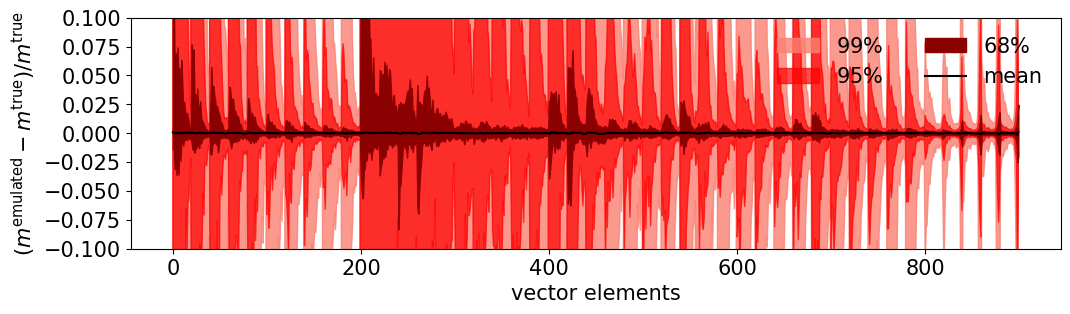

In [11]:
jax_nn = EmulatorJAX(filepath=f'outputs/jax_env_lr_updated.npz')
emulated_features = jax_nn.rescaled_predict(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()